In [1]:
import LC_model
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import scipy.stats as st
%matplotlib inline

In [2]:
def get_foldernames(folder):
    
    foldernames = [x[0][len(folder):] for x in os.walk(folder)\
                   if 'data_h' in x[0] and 'ipynb' not in x[0]]
    
    heights = []
    widths = []
    pos = []
    
    for i in range(len(foldernames)):
        
        f = foldernames[i]
        _indexes = [x for x, char in enumerate(f) if char == '_']
        heights.append(float(f[_indexes[0]+2:_indexes[1]]))
        widths.append(float(f[_indexes[1]+2:_indexes[1]+6]))
        pos.append(float(f[-4:]))
    
    return foldernames, heights, widths, pos

def get_chains_from_subfolder(master_folder,subfolder):
    
    currentpath = master_folder + subfolder
    chain_files = [currentpath+'/'+f for f in listdir(currentpath) if isfile(join(currentpath, f)) and 'chain' in f]
    CHAIN_LENGTH = 50000
    SAMPLES = 50000
    chains = np.empty((len(chain_files),SAMPLES,6))
    for i in range(len(chain_files)):
        chain_file = chain_files[i]
        #print(chain_file)
        #chains[i,:,:] = np.loadtxt(chain_file, delimiter=",",skiprows=CHAIN_LENGTH-SAMPLES)
        chains[i,:,:] = np.load(chain_file)
    return chains


def get_avg_iqr_from_chains(chains):
    
    means = np.empty(chains.shape[2])
    medians = np.empty(chains.shape[2])
    iqrs = np.empty(chains.shape[2])
    
    for i in range(means.size):
        means[i] = np.mean(chains[:,:,i])
        medians[i] = np.median(chains[:,:,i])
        iqrs[i] = st.iqr(chains[:,:,i])
        
    return means, medians, iqrs

In [6]:
master_folder = "../pos"
subfoldernames, heights, widths, pos = get_foldernames(master_folder)

"""
chains = get_chains_from_subfolder(master_folder,subfoldernames[0])

plt.hist(chains[:,:,2].flatten())
plt.show()"""
medians = np.empty((len(subfoldernames),6))
iqrs = np.empty((len(subfoldernames),6))

for i in range(len(subfoldernames)):
    medians[i,:] = np.load(master_folder + subfoldernames[i]+"/param_med.npy")
    iqrs[i,:] = np.load(master_folder + subfoldernames[i]+"/param_iqr.npy")

In [7]:
"""means = np.empty((len(subfoldernames),chains.shape[2]))
medians = np.empty((len(subfoldernames),chains.shape[2]))
iqrs = np.empty((len(subfoldernames),chains.shape[2]))

for i in range(len(subfoldernames)):
    chains = get_chains_from_subfolder(master_folder,subfoldernames[i])
    means[i,:], medians[i,:], iqrs[i,:] = get_avg_iqr_from_chains(chains)"""

'means = np.empty((len(subfoldernames),chains.shape[2]))\nmedians = np.empty((len(subfoldernames),chains.shape[2]))\niqrs = np.empty((len(subfoldernames),chains.shape[2]))\n\nfor i in range(len(subfoldernames)):\n    chains = get_chains_from_subfolder(master_folder,subfoldernames[i])\n    means[i,:], medians[i,:], iqrs[i,:] = get_avg_iqr_from_chains(chains)'

In [9]:
theta_0 = [140.5,0.0576,1.5709709, 224.22,0.47,0.19] #true values
normed_medians = np.empty_like(medians)
normed_iqrs = np.empty_like(medians)

for i in range(medians.shape[0]):
    #normed_means[i,:] = np.abs(means[i,:] - theta_0)/theta_0
    normed_medians[i,:] = np.abs(medians[i,:] - theta_0)/theta_0
    normed_iqrs[i,:]  = iqrs[i,:] / medians[i,:]

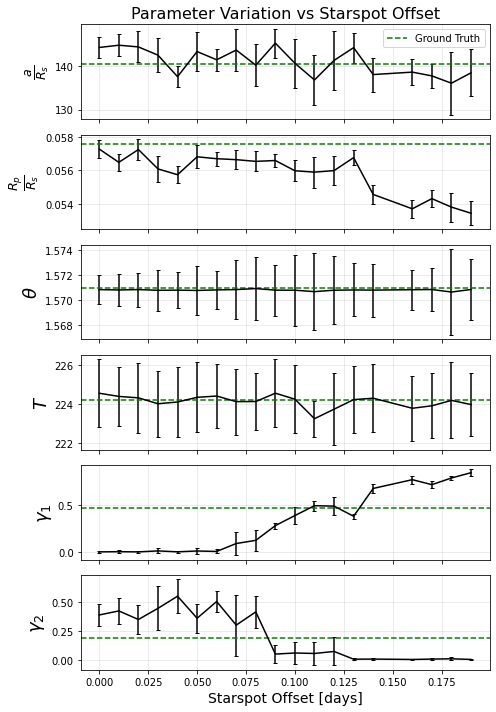

In [21]:
params = [r'$\frac{a}{R_s}$',r'$\frac{R_p}{R_s}$',r'$\theta$',r'$T$',r'$\gamma_1$',r'$\gamma_2$']
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(7,10),sharex='all')
fig.subplots_adjust(hspace=-0.3)
for i in range(6):
    idxs = np.argsort(pos)
    #ax[i].plot(np.array(pos)[idxs], 100*normed_medians[idxs,i], 
    #               color = 'k', label=params[i])
    ax[i].errorbar(np.array(pos)[idxs], medians[idxs,i], yerr=iqrs[idxs,i], 
                   color = 'k', capsize=2)
    #ax[i].legend(loc=0)
    #ax[i].set_title(params[i],size=18)

    ax[i].set_ylabel(params[i],size=18)
    ax[i].grid(alpha=0.3)
    ax[i].axhline(y=theta_0[i],linestyle='--',color='green',label='Ground Truth')
ax[0].legend(loc=1)
ax[0].set_title("Parameter Variation vs Starspot Offset",size=16)
ax[-1].set_xlabel("Starspot Offset [days]",size=14)
plt.tight_layout()
plt.savefig("Offset")
plt.show()

In [17]:
data = np.loadtxt(master_folder+'/'+subfoldernames[0]+"/data.txt",delimiter=",",max_rows=2)
data[1] = data[1]*1e-6+1

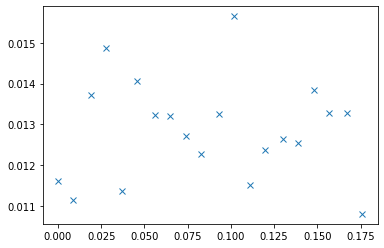

In [21]:
residuals = np.empty(len(subfoldernames))
for i in range(len(subfoldernames)):

    filepath = master_folder+subfoldernames[i]+"/data.txt"
    
    data = np.loadtxt(filepath,delimiter=",",max_rows=2)
    data[1] = data[1]*1e-6+1
    time = data[0]
    flux = data[1]
    z0,p,inc,T = medians[i,:-2]
    g1,g2 = medians[i,-2:]

    fit = LC_model.transit_fit([z0,p,inc,T],\
                           [g1,g2],method="quad_ld") 

    # g1,g2 are the ld_coef
    y_mcmc = fit.transit_model(time)

    residuals[i]=np.sum(np.abs(y_mcmc-flux))

plt.plot(pos,residuals,'x')
plt.show()